In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_validate, TimeSeriesSplit, train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from prophet import Prophet
import warnings

SEED = 42
warnings.filterwarnings('ignore')

### Необходимые Функции

In [ ]:
# Визуализируем ряд
def plot_sereis(series, x_name, y_name):
    plt.figure(figsize=(20,8))
    plt.plot(series)
    plt.grid(True)
    plt.xlabel(x_name)
    plt.ylabel(y_name)


def check_stationarity(series):
    dikki_fuller_values = sm.tsa.stattools.adfuller(series.values)
    print('Diki-Fuller p-value: %.3f' %dikki_fuller_values[1])


def plot_decomposition(series, figsize = (12, 9), grid=True):
    ts_compnts = sm.tsa.seasonal_decompose(series)
    titles = ['Origianl', 'Trend', 'Seasonal', 'Resid']

    fig, ax = plt.subplots(nrows=4, ncols=1,figsize=figsize)
    plt.tight_layout()
    ax[0].set_title('Time Series Decomposition')

    ax[0].plot(series)
    ax[1].plot(ts_compnts.trend)
    ax[2].plot(ts_compnts.seasonal)
    ax[3].plot(ts_compnts.resid)

    for indx, title in enumerate(titles):
        ax[indx].set_ylabel(title)
        ax[indx].grid(True)


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

### Загрузка Данных

In [ ]:
data = pd.read_csv('/content/orders_new.csv', delimiter=';', encoding='cp1251', parse_dates=['Дата время заказа'])
data = data.sort_values(by='Дата время заказа')
data.head()

,Дата время заказа,ID заказа,ID клиента,Сумма заказа,Сумма скидки,Артикул товара,Наименование,Цена,Количество,Сумма,Скидка,Область/Город,Адрес из базы,Доставка/Самовывоз
39774,01.01.2017 09:56:40,15071,2224,312.42,0.0,6809,Пластиковая метла с телескопической ручкой,312.42,1.0,312.42,0.00,NaN,NaN,Самовывоз
39775,01.01.2017 12:45:12,15072,12168,2538.40,0.0,8623,Комплект для уборки полов CleanFLoor Mini,2538.40,1.0,2538.40,362.54,Екатеринбург,"г.Тюмень , улица Орловская, дом 50, квартира 36",Самовывоз
39776,01.01.2017 13:53:34,15073,2224,1272.42,0.0,4107,Алюминиевый формованный движок для снега,960.00,1.0,960.00,0.00,NaN,NaN,Самовывоз
39777,01.01.2017 13:53:34,15073,2224,1272.42,0.0,6809,Пластиковая метла с телескопической ручкой,312.42,1.0,312.42,0.00,NaN,NaN,Самовывоз
39778,01.01.2017 16:44:11,15074,12170,842.00,0.0,9276,Складной металлический флаундер,229.00,1.0,229.00,0.00,Москва,"Бескудниковский б-р, д. 48,к.5 кв.31",Самовывоз


### Предварительный Анализ Данных

In [ ]:
# отберем топ товаров
top_k = 5

selected_items = data['Артикул товара'].value_counts().head(top_k).index.tolist()
selected_items

[232, 4233, 3955, 505, 816]

In [ ]:
data['Артикул товара'].value_counts().head(top_k)

,count
Артикул товара,
232,2025
4233,1031
3955,1001
505,896
816,786


- больше всего данных для товара с артикулом `232`

In [ ]:
# определим уровень аггрегации рядов
item_data = data[data['Артикул товара'] == selected_items[0]]
item_data['Дата время заказа'] = pd.to_datetime(item_data['Дата время заказа'], format='%d.%m.%Y %H:%M:%S')

# сгенерируем признаки времени
item_data['date'] = item_data['Дата время заказа'].dt.to_period('D')
item_data['week_start'] = item_data['Дата время заказа'].dt.to_period('W')
item_data['month'] = item_data['Дата время заказа'].dt.to_period('M')

In [ ]:
# произведем аггрегацию на разных уровнях
item_data_daily = item_data.groupby('date')['Количество'].sum()
item_data_weekly = item_data.groupby('week_start')['Количество'].sum()
item_data_monthly = item_data.groupby('month')['Количество'].sum()

In [ ]:
# в данных должны быть все дни/недели/месяца
full_index_daily = pd.period_range(
    start=item_data_daily.index.min(),
    end=item_data_daily.index.max(),
    freq='D'
)

full_index_weekly = pd.period_range(
    start=item_data_weekly.index.min(),
    end=item_data_weekly.index.max(),
    freq='W'
)

full_index_monthly = pd.period_range(
    start=item_data_monthly.index.min(),
    end=item_data_monthly.index.max(),
    freq='M'
)

In [ ]:
# реиндексируем, чтобы иметь все дни/недели/месяца
item_data_daily = item_data_daily.reindex(full_index_daily, fill_value=0)
item_data_daily.index = item_data_daily.index.to_timestamp()

item_data_weekly = item_data_weekly.reindex(full_index_weekly, fill_value=0)
item_data_weekly.index = item_data_weekly.index.to_timestamp()

item_data_monthly = item_data_monthly.reindex(full_index_monthly, fill_value=0)
item_data_monthly.index = item_data_monthly.index.to_timestamp()

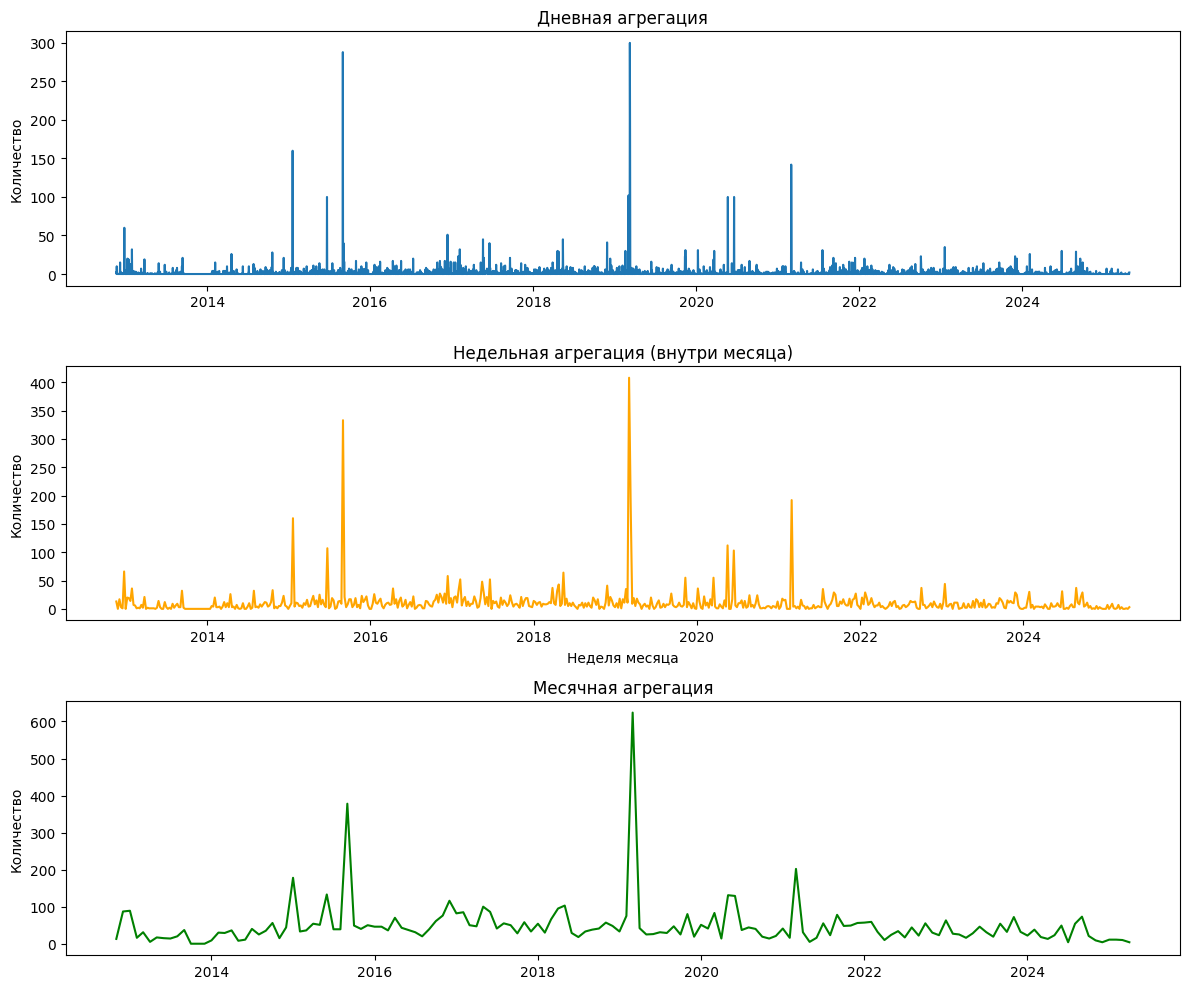

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=False)

# График 1: По дням
axes[0].plot(item_data_daily.index, item_data_daily.values)
axes[0].set_title('Дневная агрегация')
axes[0].set_ylabel('Количество')

# График 2: По неделям месяца
axes[1].plot(item_data_weekly.index, item_data_weekly.values, color='orange')
axes[1].set_title('Недельная агрегация (внутри месяца)')
axes[1].set_ylabel('Количество')
axes[1].set_xlabel('Неделя месяца')

# График 3: По месяцам
axes[2].plot(item_data_monthly.index, item_data_monthly.values, color='green')
axes[2].set_title('Месячная агрегация')
axes[2].set_ylabel('Количество')

plt.tight_layout()
plt.show()

- Самым оптимальным будет использовать агрегацию на уровне недели -> достаточно данных для моделирования + он не шумные в сравнении с дневной агрегацией

In [ ]:
# данные для моделирования
item_data_weekly

,Количество
2012-11-19,13.0
2012-11-26,0.0
2012-12-03,17.0
2012-12-10,3.0
2012-12-17,1.0
...,...
2025-03-24,0.0
2025-03-31,0.0
2025-04-07,1.0
2025-04-14,0.0


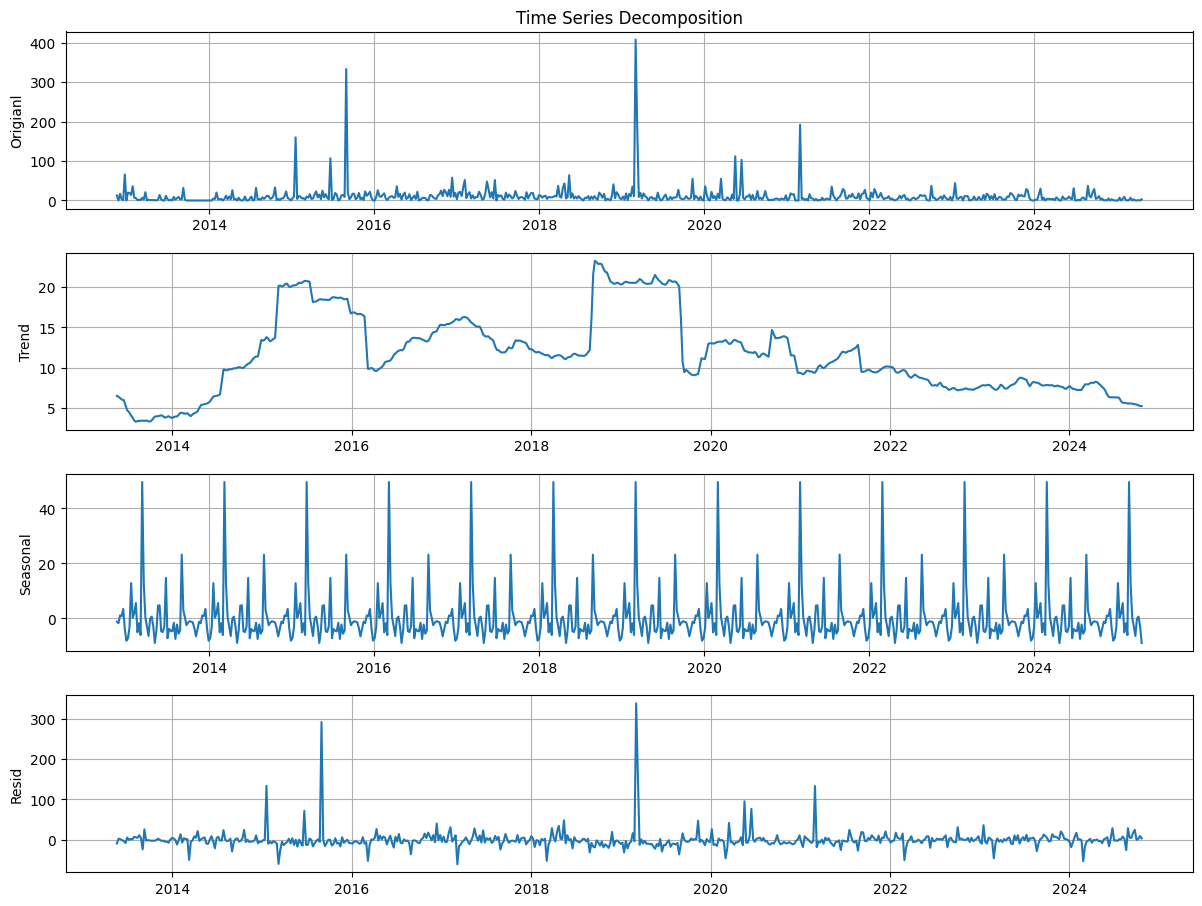

In [ ]:
# взглянем на декомпозицю временного ряда
plot_decomposition(item_data_weekly)

- Временной ряд имеет восходящий тренд, особенно выраженный после 2018 года.
- Наблюдается сезонность, что говорит о повторяющихся паттернах в данных (например, сезонные продажи, погодные колебания и т. д.).
- Остатки в основном случайны, но наличие выбросов требует дополнительной проверки на предмет аномалий или внешних воздействий.


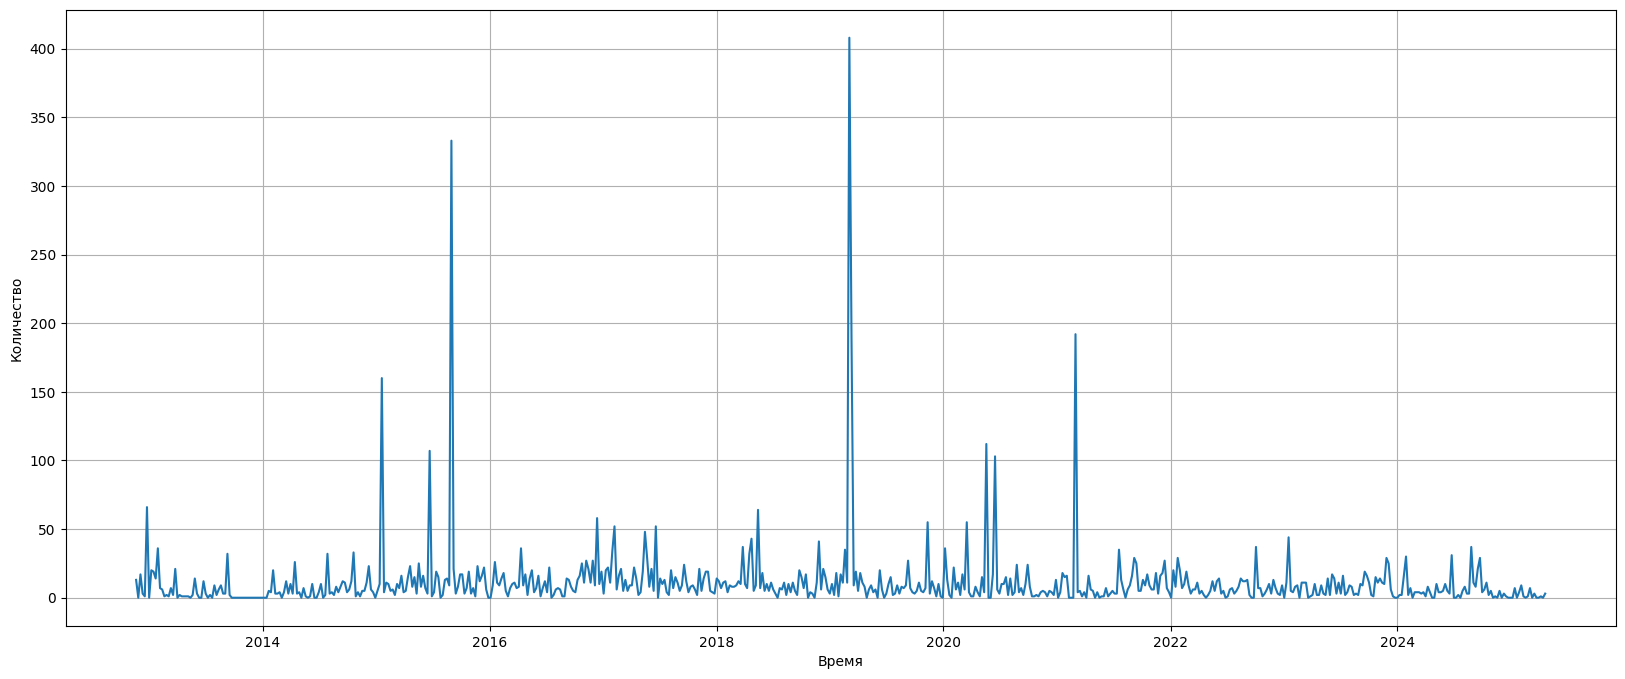

In [ ]:
plot_sereis(item_data_weekly, x_name='Время', y_name='Количество')

- Данный ряд сожержит выбросы и шум, что может осложнить моделирование. Сглаживать или нет ряд можно определить при помощи эксперимента -  сравнить точность моделей на сглаженных и исходных данных через кросс-валидацию.

# Распределение Таргета

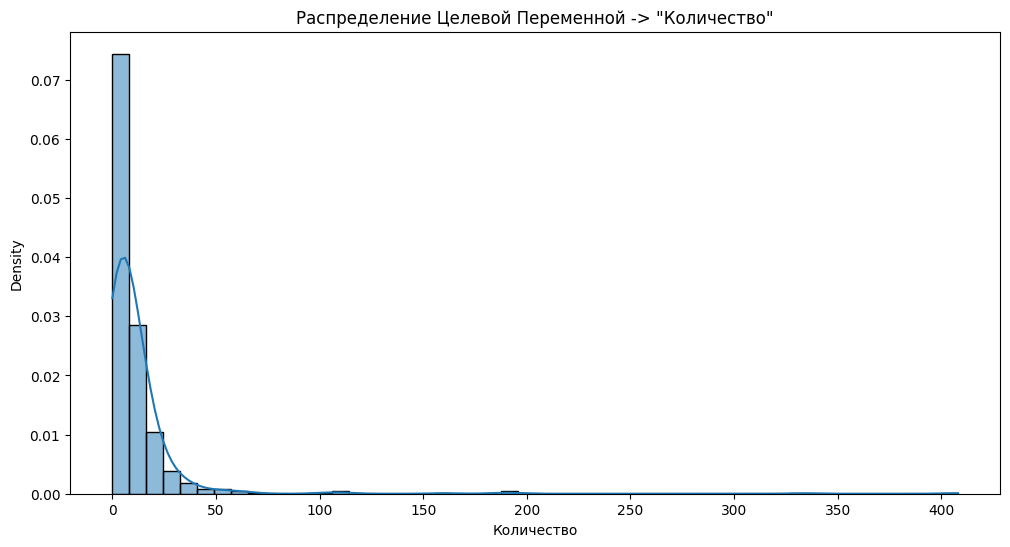

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(item_data_weekly, bins=50, kde=True, stat="density")
plt.title('Распределение Целевой Переменной -> "Количество"');

- Распределение целевой переменной "Количество" (продажи товара в неделю) показывает, что данные имеют сильную асимметрию (скошены вправо) с преобладанием нулевых и малых значений

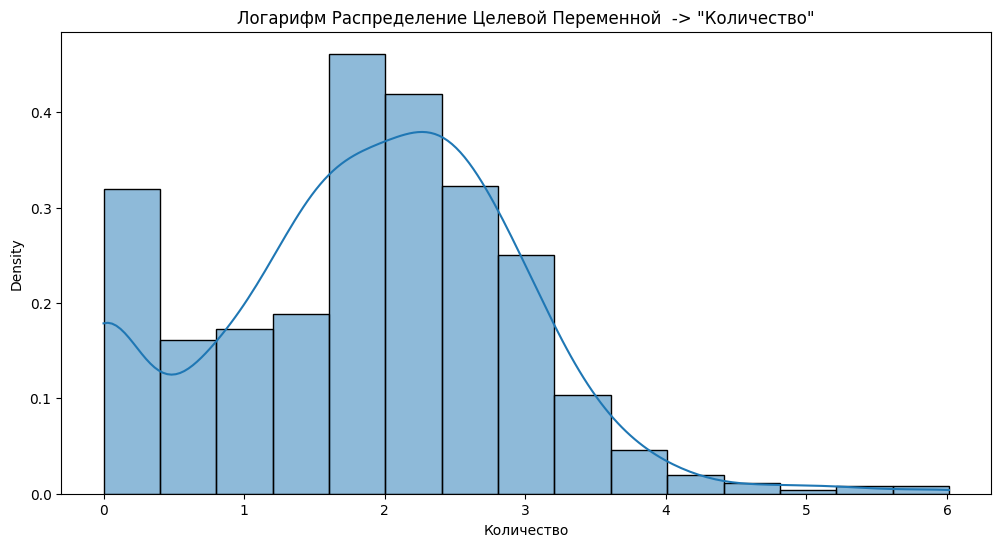

In [ ]:
# логарифмирование таргета -> для лучшего прогнозирования
item_data_weekly_log = item_data_weekly.apply(lambda x: np.log(x + 1))

plt.figure(figsize=(12, 6))
sns.histplot(item_data_weekly_log, bins=15, kde=True, stat="density")
plt.title('Логарифм Распределение Целевой Переменной  -> "Количество"');

- После логарифмирования целевой переменной "Количество" (продажи товара в неделю) распределение стало ближе к нормальному, но сохранило некоторые особенности
- Правая часть графика (значения >4) указывает на то, что в данных есть редкие, но значимые всплески продаж. Это может быть связано с:
  - Сезонностью (например, праздники).
  - Акциями или рекламными кампаниями.
  - Выбросами (аномалиями в данных).

# Сглаживание Таргета

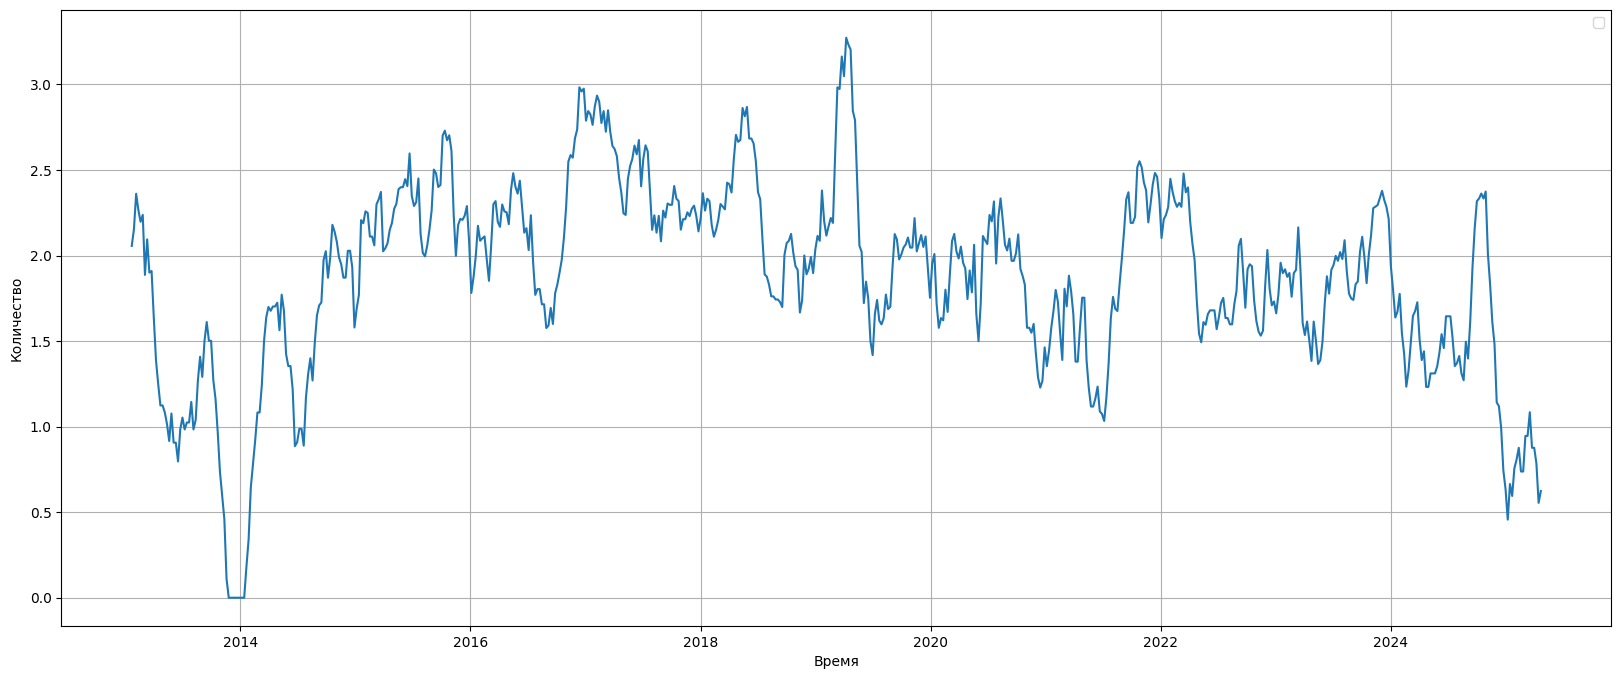

In [ ]:
# сглаживаем
window_size = 10
item_data_weekly_log_smoothed = item_data_weekly_log.rolling(window=window_size, center=False).mean()

# удаляем пропуски
item_data_weekly_log_smoothed = item_data_weekly_log_smoothed.dropna()

# визуализируем
plt.figure(figsize=(20,8))
plt.plot(item_data_weekly_log_smoothed)
plt.xlabel('Время')
plt.ylabel('Количество')
plt.grid()
plt.legend()
plt.show()

# Метрики


In [ ]:
# Определим метрику MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Определим RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Определим WAPE
def weighted_absolute_percentage_error(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

# Определим SMAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    """
    """
    # Защита от деления на ноль (если y_true и y_pred оба нули)
    mask = (np.abs(y_true) + np.abs(y_pred)) != 0
    y_true = np.where(mask, y_true, 1e-6)  # заменяем нули на маленькое число
    y_pred = np.where(mask, y_pred, 1e-6)

    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# CatBoost

In [ ]:
# FEATURE ENGINEERING
series_df = item_data_weekly_log_smoothed.reset_index().rename(columns={'index': 'date'})

# генерируем временные признаки
series_df['year'] = series_df['date'].dt.year
series_df['month'] = series_df['date'].dt.month
series_df['week_of_year'] = series_df['date'].dt.isocalendar().week
series_df['day_of_month'] = series_df['date'].dt.day
series_df['week_of_month'] = (series_df['day_of_month'] - 1) // 7 + 1
series_df['is_winter'] = series_df['month'].isin([12, 1, 2]).astype(int)
series_df['is_spring'] = series_df['month'].isin([3, 4, 5]).astype(int)
series_df['is_summer'] = series_df['month'].isin([6, 7, 8]).astype(int)
series_df['is_fall'] = series_df['month'].isin([9, 10, 11]).astype(int)
series_df['is_month_start'] = series_df['day_of_month'].isin([0, 10]).astype(int)
series_df['is_month_mid'] = series_df['day_of_month'].isin([11, 19]).astype(int)
series_df['is_month_end'] = series_df['day_of_month'].isin([20, 31]).astype(int)

# лаги ряда
series_df['lag_1'] = series_df['Количество'].shift(1)
series_df['lag_4'] = series_df['Количество'].shift(4)
series_df['lag_52'] = series_df['Количество'].shift(52)

# скользящие средние
series_df['rolling_mean_4'] = series_df['Количество'].shift(1).rolling(window=4, center=False).mean()
series_df['rolling_mean_12'] = series_df['Количество'].shift(1).rolling(window=12, center=False).mean()

# удаление строк с NaN (из-за признаках на лагах)
series_df.dropna(inplace=True)
series_df

,date,Количество,year,month,week_of_year,day_of_month,week_of_month,is_winter,is_spring,is_summer,is_fall,is_month_start,is_month_mid,is_month_end,lag_1,lag_4,lag_52,rolling_mean_4,rolling_mean_12
52,2014-01-20,0.179176,2014,1,4,20,3,1,0,0,0,0,0,1,0.000000,0.000000,2.056187,0.000000,0.158690
53,2014-01-27,0.340120,2014,1,5,27,4,1,0,0,0,0,0,0,0.179176,0.000000,2.153373,0.044794,0.112224
54,2014-02-03,0.644572,2014,2,6,3,1,1,0,0,0,0,0,0,0.340120,0.000000,2.361317,0.129824,0.090722
55,2014-02-10,0.783201,2014,2,7,10,2,1,0,0,0,1,0,0,0.644572,0.000000,2.266871,0.290967,0.106144
56,2014-02-17,0.921831,2014,2,8,17,3,1,0,0,0,0,0,0,0.783201,0.179176,2.197556,0.486767,0.162256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,2025-03-24,0.876405,2025,3,13,24,4,0,1,0,0,0,0,0,1.084349,0.737776,1.726930,0.928391,0.770195
636,2025-03-31,0.876405,2025,3,14,31,5,0,1,0,0,0,0,1,0.876405,0.945720,1.512923,0.963049,0.790261
637,2025-04-07,0.784776,2025,4,15,7,1,0,1,0,0,0,0,0,0.876405,0.945720,1.389247,0.945720,0.825258
638,2025-04-14,0.554518,2025,4,16,14,2,0,1,0,0,0,0,0,0.784776,1.084349,1.440330,0.905484,0.835291


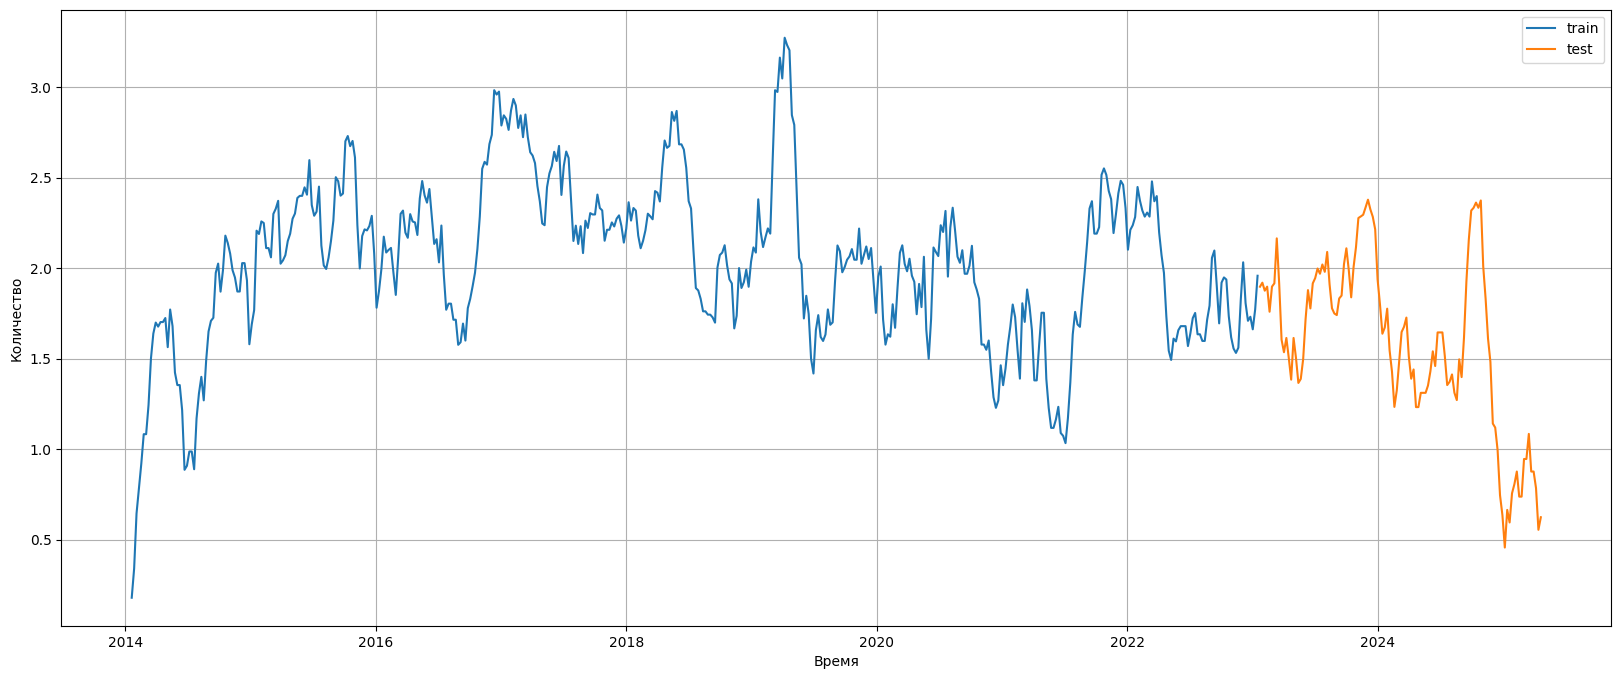

In [ ]:
# TRAIN/TEST SPLIT
X = series_df.drop(['Количество', 'date'], axis='columns')
y = series_df.set_index('date')['Количество']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

plt.figure(figsize=(20,8))
plt.plot(y_train, label='train')
plt.plot(y_test, label='test')
plt.xlabel('Время')
plt.ylabel('Количество')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# статистики по фичам
X.describe()

,year,month,week_of_year,day_of_month,week_of_month,is_winter,is_spring,is_summer,is_fall,is_month_start,is_month_mid,is_month_end,lag_1,lag_4,lag_52,rolling_mean_4,rolling_mean_12
count,588.000000,588.000000,588.0,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000
mean,2019.187075,6.421769,26.209184,15.734694,2.700680,0.251701,0.258503,0.246599,0.243197,0.034014,0.064626,0.054422,1.941741,1.937973,1.925085,1.939994,1.934540
std,3.263400,3.461987,15.10944,8.797418,1.269025,0.434360,0.438185,0.431398,0.429379,0.181418,0.246074,0.227041,0.494381,0.506138,0.531646,0.485961,0.464901
min,2014.000000,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090722
25%,2016.000000,3.000000,13.0,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.657327,1.657327,1.657725,1.654793,1.668613
50%,2019.000000,6.000000,26.0,16.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.988578,1.988578,1.988578,1.973027,1.945970
75%,2022.000000,9.000000,39.0,23.000000,4.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.273213,2.273213,2.263057,2.255036,2.257983
max,2025.000000,12.000000,53.0,31.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.273368,3.273368,3.273368,3.189621,2.893840


In [ ]:
# определяем основной разрез метрик
scoring = {
    'rmse': make_scorer(root_mean_squared_error),
    'wape': make_scorer(weighted_absolute_percentage_error),
    'smape': make_scorer(symmetric_mean_absolute_percentage_error)
}

# определяем модель c начальными параметрами
model = CatBoostRegressor(
    iterations=100,
    learning_rate=0.48,
    depth=6,
    l2_leaf_reg=3,
    logging_level='Silent',
    loss_function='MAE',
    bootstrap_type='Bayesian',
    random_strength=1.5,
    random_seed=SEED,
    early_stopping_rounds=100,
    task_type='CPU'
)

# кросс-Валидируемся
cv_results = cross_validate(
    model, X=X_train, y=y_train,
    cv=TimeSeriesSplit(n_splits=5),
    scoring=scoring,
    error_score='raise'
)

# результаты CV
print('CV Results: ')
cv_df = pd.DataFrame(cv_results)
cv_df[cv_df.columns[2:]].mean()

CV Results: 


,0
test_rmse,0.283901
test_wape,0.109660
test_smape,11.222951


In [ ]:
cv_results

{'fit_time': array([0.3721838 , 0.35878921, 0.30015421, 0.36237144, 0.20118189]),
 'score_time': array([0.00781751, 0.00993538, 0.00646567, 0.00419307, 0.00400901]),
 'test_rmse': array([0.45823751, 0.18191261, 0.2097356 , 0.32480399, 0.24481284]),
 'test_wape': array([0.15170104, 0.06328975, 0.08274393, 0.15341757, 0.09714915]),
 'test_smape': array([15.4540817 ,  6.39938689,  8.10454747, 15.75077964, 10.40595682])}

In [ ]:
model.fit(X_train, y_train)
model_preds = model.predict(X_test)

# снова смотрим на метрики
print('SMAPE (Test Data): ', symmetric_mean_absolute_percentage_error(y_test, model_preds))
print('RMSE (Test Data): ', root_mean_squared_error(y_test, model_preds))
print('WAPE (Test Data)', weighted_absolute_percentage_error(y_test, model_preds))

SMAPE (Test Data):  17.681871008978554
RMSE (Test Data):  0.32812194698422154
WAPE (Test Data) 0.15071847667314522


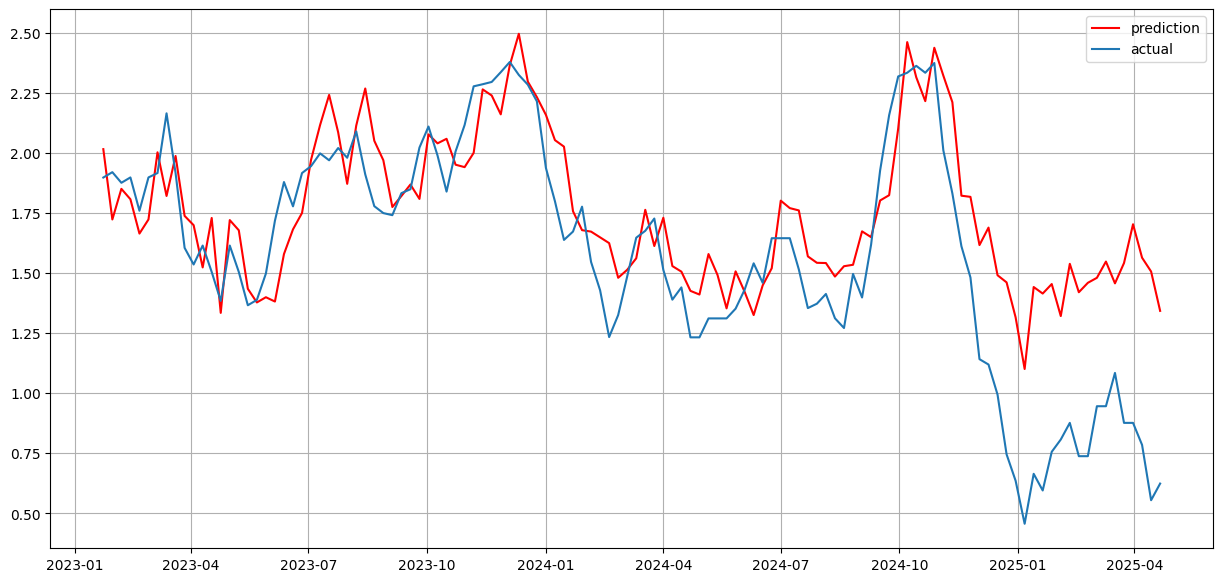

In [ ]:
# оформим прогноз в DataFrame
forecast_df = pd.DataFrame(y_test)
forecast_df['forecast'] = model_preds

# визуализируем прогноз модели
plt.figure(figsize=(15, 7))
plt.plot(forecast_df['forecast'], "r", label="prediction")
plt.plot(forecast_df['Количество'], label="actual")
plt.legend(loc="best")
plt.grid(True);

# LSTM

In [ ]:
# скейлим данные
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(item_data_weekly_log_smoothed.values.reshape(-1, 1))

# создадим данные для обучения LSTM
SEQ_LEN = 5
X, y = create_sequences(data=data_scaled, seq_length=SEQ_LEN)

# TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# reshape (LSTM требует строгий формат входных векторов)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# определяем модель
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(SEQ_LEN, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# обучаем модель
tscv = TimeSeriesSplit(n_splits=3)

cv_results = {
    'smape': [],
    'rmse': [],
    'wape': [],
}

# кросс-валидируем
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model.fit(X_train, y_train, epochs=20, batch_size=32, shuffle=False, verbose=0)

    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

    cv_results['smape'].append(float(symmetric_mean_absolute_percentage_error(y_test_original, y_pred)))
    cv_results['rmse'].append(float(root_mean_squared_error(y_test_original, y_pred)))
    cv_results['wape'].append(float(weighted_absolute_percentage_error(y_test_original, y_pred)))

    print('Fold -> Done')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Fold -> Done
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Fold -> Done
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold -> Done


In [ ]:
cv_results

{'smape': [9.148111648051875, 10.124202585924328, 13.055476182063707],
 'rmse': [0.260192953623473, 0.24847536803876666, 0.26356708942880486],
 'wape': [0.08975360988703629, 0.09778113853462068, 0.12339991692407044]}

In [ ]:
model.fit(X_train, y_train)
model_preds = model.predict(X_test)

# снова смотрим на метрики
print('\nSMAPE (Test Data): ', symmetric_mean_absolute_percentage_error(y_test, model_preds))
print('RMSE (Test Data): ', root_mean_squared_error(y_test, model_preds))
print('WAPE (Test Data)', weighted_absolute_percentage_error(y_test, model_preds))

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0072
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

SMAPE (Test Data):  12.456179584518864
RMSE (Test Data):  0.07533150122650012
WAPE (Test Data) 0.11674015173461609


In [ ]:
forecast_df.head()

,Количество,forecast
date,,
2023-01-23,1.897561,2.015700
2023-01-30,1.919876,1.722959
2023-02-06,1.875692,1.850453
2023-02-13,1.898007,1.807232
2023-02-20,1.759377,1.664285


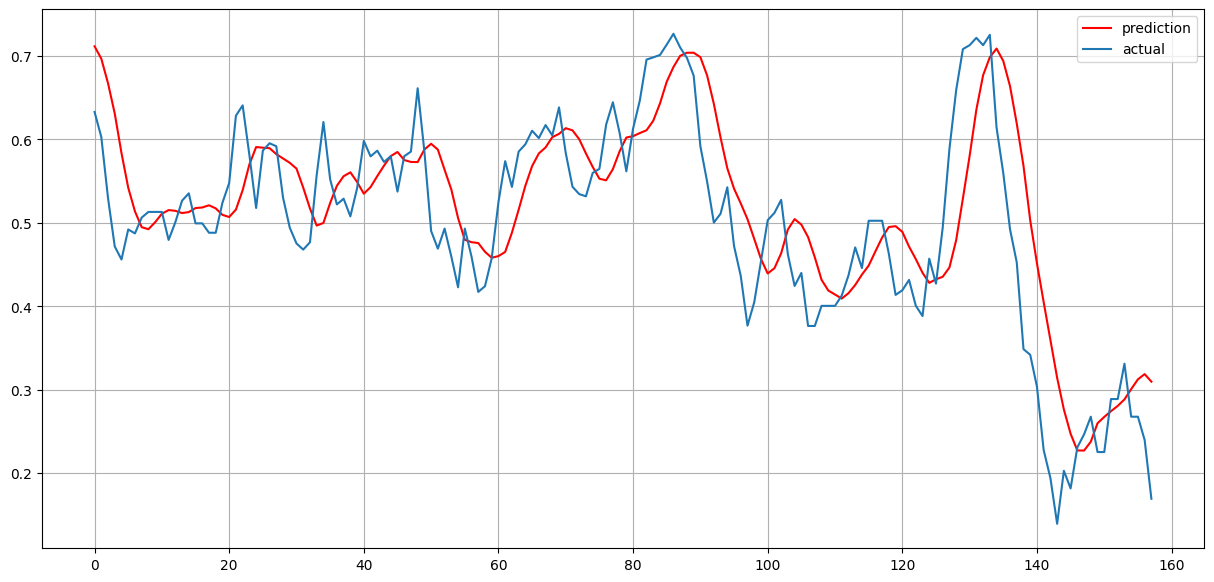

In [ ]:
# оформим прогноз в DataFrame
forecast_df = pd.DataFrame(y_test)
forecast_df['forecast'] = model_preds

# визуализируем прогноз модели
plt.figure(figsize=(15, 7))
plt.plot(forecast_df['forecast'], "r", label="prediction")
plt.plot(forecast_df[0], label="actual")
plt.legend(loc="best")
plt.grid(True);

# Prophet

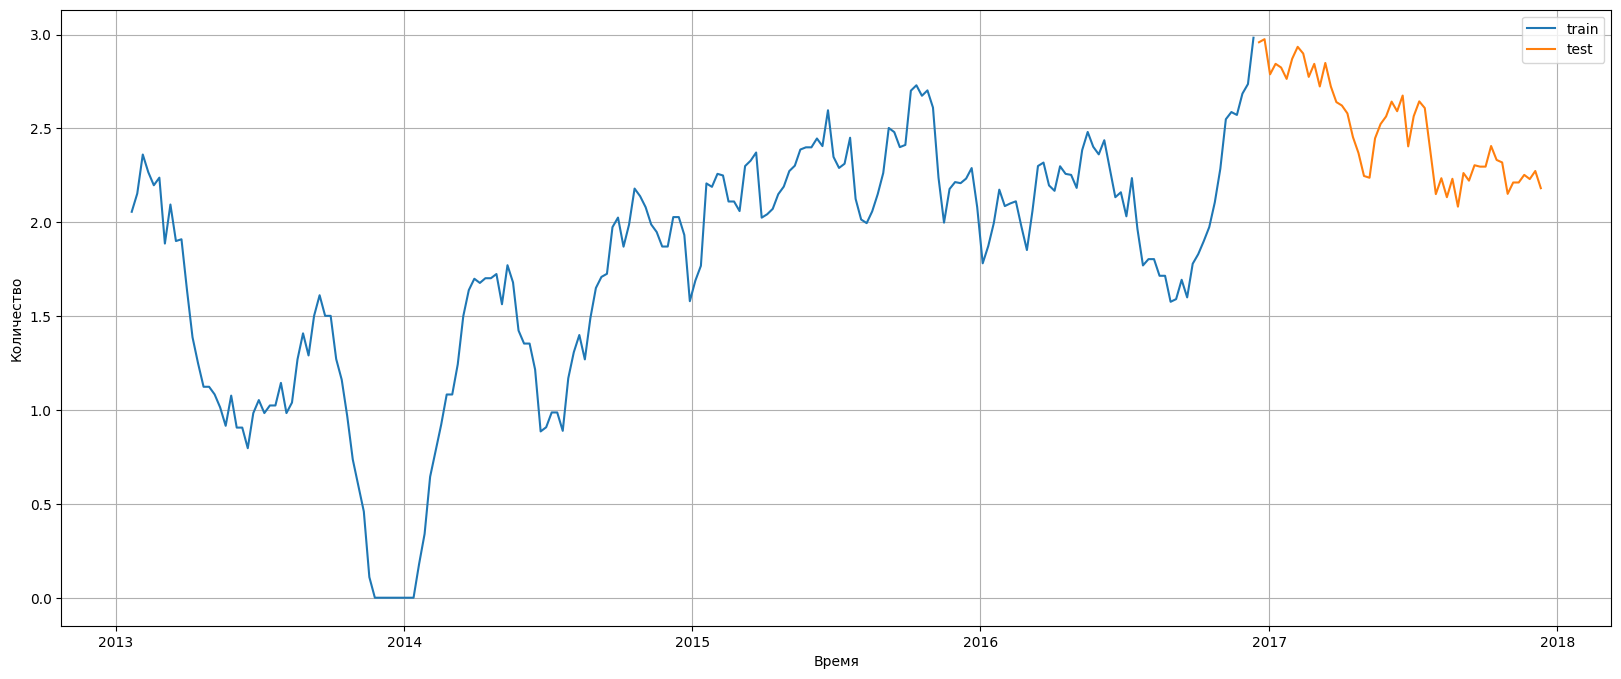

In [ ]:
# подготавливаем данные для Prophet
prophet_df = pd.DataFrame()
prophet_df['ds'] = item_data_weekly_log_smoothed.index
prophet_df['y'] = item_data_weekly_log_smoothed.values

# TRAIN/TEST SPLIT
train_data, test_data = train_test_split(prophet_df, test_size=0.2, shuffle=False)

plt.figure(figsize=(20,8))
plt.plot(train_data.set_index('ds'), label='train')
plt.plot(test_data.set_index('ds'), label='test')
plt.xlabel('Время')
plt.ylabel('Количество')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# определяем модель
model = Prophet(
    yearly_seasonality='auto',           # Годовая сезонность
    weekly_seasonality='auto',           # Недельная сезонность
    daily_seasonality='auto',           # Отключаем, если нет дневных данных
    seasonality_mode='multiplicative', # Для мультипликативных эффектов
    changepoint_prior_scale=0.05,      # Регуляризация для сглаживания тренда
    seasonality_prior_scale=10.0       # Контроль силы сезонности
)

# обучаем
model.fit(train_data)

# предсказываем
future_df = model.make_future_dataframe(periods=len(test_data), freq='W')
forecast_summary_df = model.predict(future_df)

# извлекаем прогноз
model_preds = forecast_summary_df['yhat'][-len(test_data):]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptsgnttst/y7yb6zvj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptsgnttst/w7x7rl8n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53921', 'data', 'file=/tmp/tmptsgnttst/y7yb6zvj.json', 'init=/tmp/tmptsgnttst/w7x7rl8n.json', 'output', 'file=/tmp/tmptsgnttst/prophet_modelr0k6z57a/prophet_model-20250505225355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:53:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:53:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# оцениваем качество
print('SMAPE (Test Data): ', symmetric_mean_absolute_percentage_error(test_data['y'], model_preds))
print('RMSE (Test Data): ', root_mean_squared_error(test_data['y'], model_preds))
print('WAPE (Test Data)', weighted_absolute_percentage_error(test_data['y'], model_preds))

SMAPE (Test Data):  13.235510971945526
RMSE (Test Data):  0.415975590568313
WAPE (Test Data) 0.13198989552383397


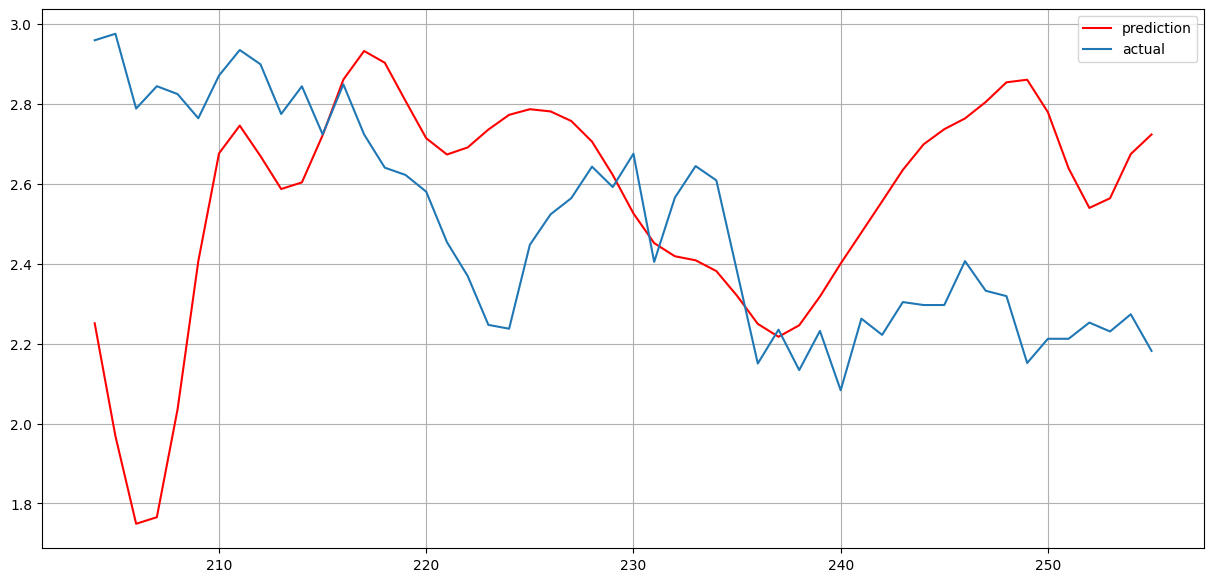

In [ ]:
# оформим прогноз в DataFrame
forecast_df = pd.DataFrame(test_data['y'])
forecast_df['forecast'] = model_preds

# визуализируем прогноз модели
plt.figure(figsize=(15, 7))
plt.plot(forecast_df['forecast'], "r", label="prediction")
plt.plot(forecast_df['y'], label="actual")
plt.legend(loc="best")
plt.grid(True);

# SARIMA

In [ ]:
# !pip install --force-reinstall numpy==1.24.4 pmdarima

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from itertools import product

In [ ]:
# проверим исходный ряд на стационарность
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(item_data_weekly_log_smoothed)[1])

Критерий Дики-Фуллера: p=0.554952


- Ряд является нестационарным, применим первые разности

In [ ]:
item_data_weekly_log_smoothed_diff = item_data_weekly_log_smoothed.diff().dropna()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(item_data_weekly_log_smoothed_diff)[1])

Критерий Дики-Фуллера: p=0.000000


- Ряд является стационарным -> можно моделировать при помщи SARIMA

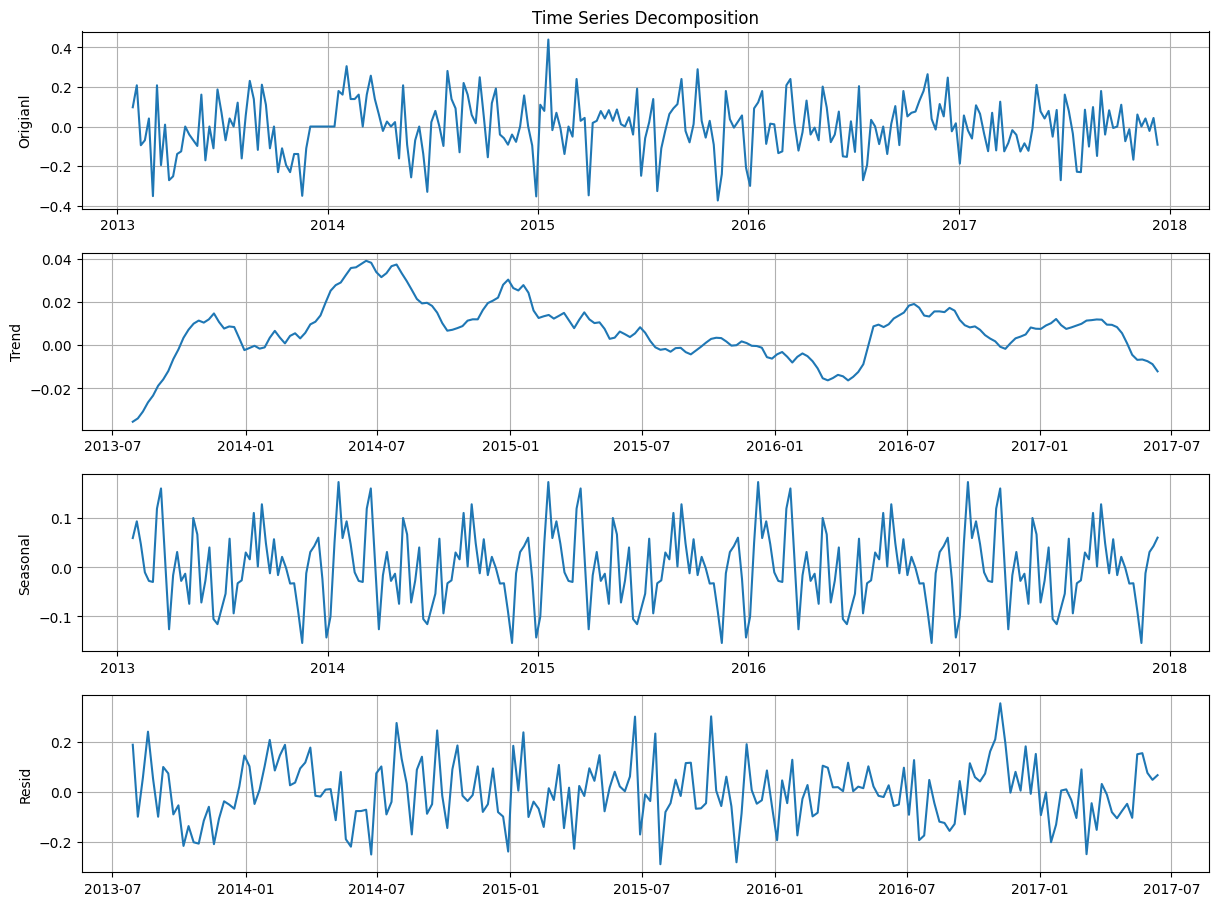

In [ ]:
plot_decomposition(item_data_weekly_log_smoothed_diff)

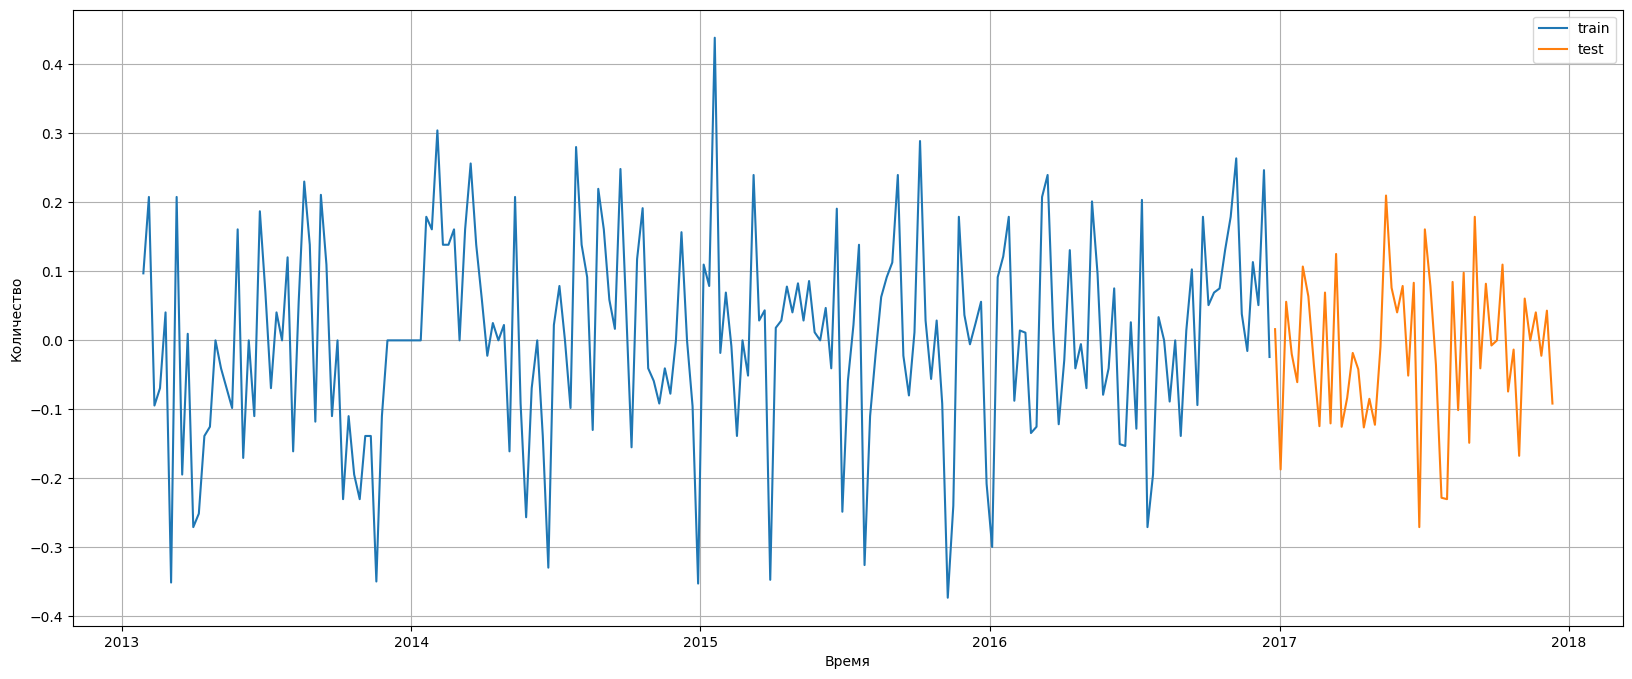

In [ ]:
# TRAIN/TEST SPLIT
train_data, test_data = train_test_split(item_data_weekly_log_smoothed_diff, test_size=0.2, shuffle=False)

plt.figure(figsize=(20,8))
plt.plot(train_data, label='train')
plt.plot(test_data, label='test')
plt.xlabel('Время')
plt.ylabel('Количество')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# опеделяем границы параметров модели
Q = range(0,3)
q = range(0,3) # 0-2

p = range(0,3) # 0-4
P = range(0,3) # 0-1

D = 1
d = 1
s = 4

# общее число комбинаций параметров модели
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print('Total Params Combinations: ', len(parameters_list))

Total Params Combinations:  81


In [ ]:
%%time

results = []
best_aic = float('inf')

for param in tqdm(parameters_list, desc="Fitting SARIMA models", unit="model"):
    # Т.к. моедель не обучается на некоторых параметрах, то заключим критичный код в try-except блок
    try:
        model = sm.tsa.statespace.SARIMAX(
            train_data,
            order=(param[0], d, param[1]), # p,d,q params
            seasonal_order=(param[2], D, param[3], s) # P, D, Q, s params
        ).fit(disp=-1)

    # Если модель не обучается на каких-то параметрах, выводим их
    except ValueError:
        print('Wrong Params: ', param)
        continue

    # Смотрим на значения информационного критерия Акайке и сохраняем лучшую модель
    current_aic = model.aic
    if current_aic < best_aic:
        best_model = model
        best_aic = current_aic
        best_param = param

    results.append([param, current_aic])

# результаты
modesl_results = pd.DataFrame(results)
modesl_results.columns = ['params', 'aic']

# выводим топ-5 лучших
modesl_results.sort_values(by='aic').head()

Fitting SARIMA models: 100%|██████████| 81/81 [01:12<00:00,  1.11model/s]

CPU times: user 2min 4s, sys: 299 ms, total: 2min 4s
Wall time: 1min 12s


,params,aic
44,"(1, 1, 2, 2)",-184.944525
70,"(2, 1, 2, 1)",-184.938926
79,"(2, 2, 2, 1)",-184.344225
76,"(2, 2, 1, 1)",-184.332779
71,"(2, 1, 2, 2)",-184.320642


In [ ]:
print(best_model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                             Количество   No. Observations:                  204
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 4)   Log Likelihood                  99.472
Date:                                Mon, 05 May 2025   AIC                           -184.945
Time:                                        22:55:09   BIC                           -161.891
Sample:                                    01-28-2013   HQIC                          -175.614
                                         - 12-19-2016                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1644      0.080      2.064      0.039       0.008       0.320
ma.

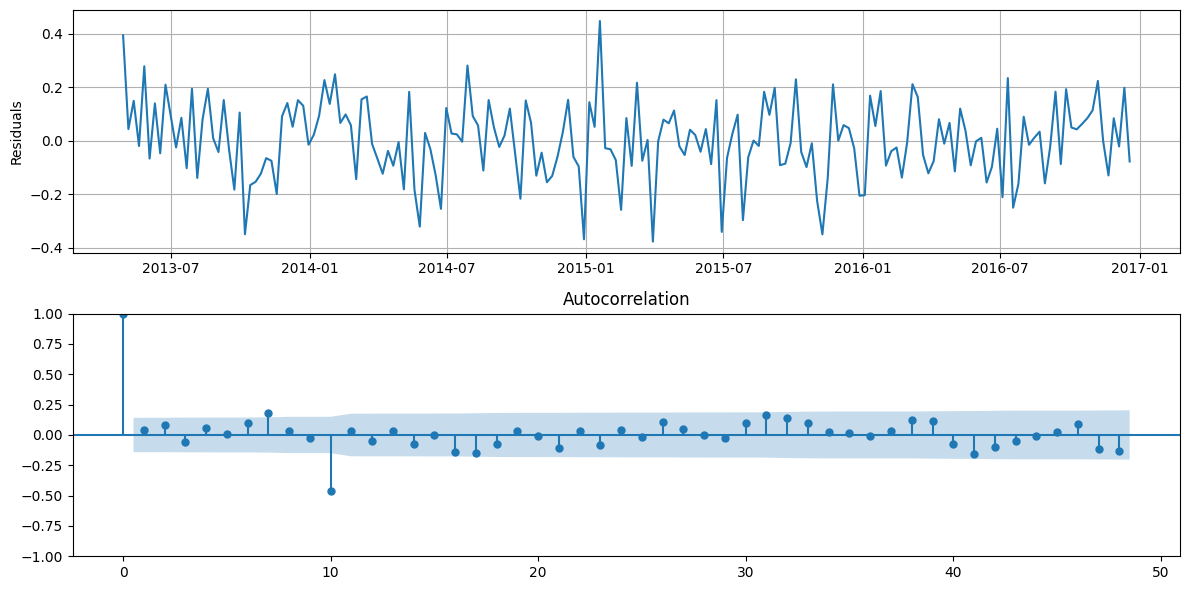

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

ax[0].plot(best_model.resid[13:])
ax[0].grid(True)
ax[0].set_ylabel('Residuals')

sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax[1])
plt.tight_layout()

In [ ]:
from scipy import stats

print("Diki-Fuller Criterion: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])
print("Student's Criterion: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])

Diki-Fuller Criterion: p=0.000000
Student's Criterion: p=0.833439


Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Следовательно, наша модель хороша.

Посмотрим, насколько хорошо модель описывает данные:

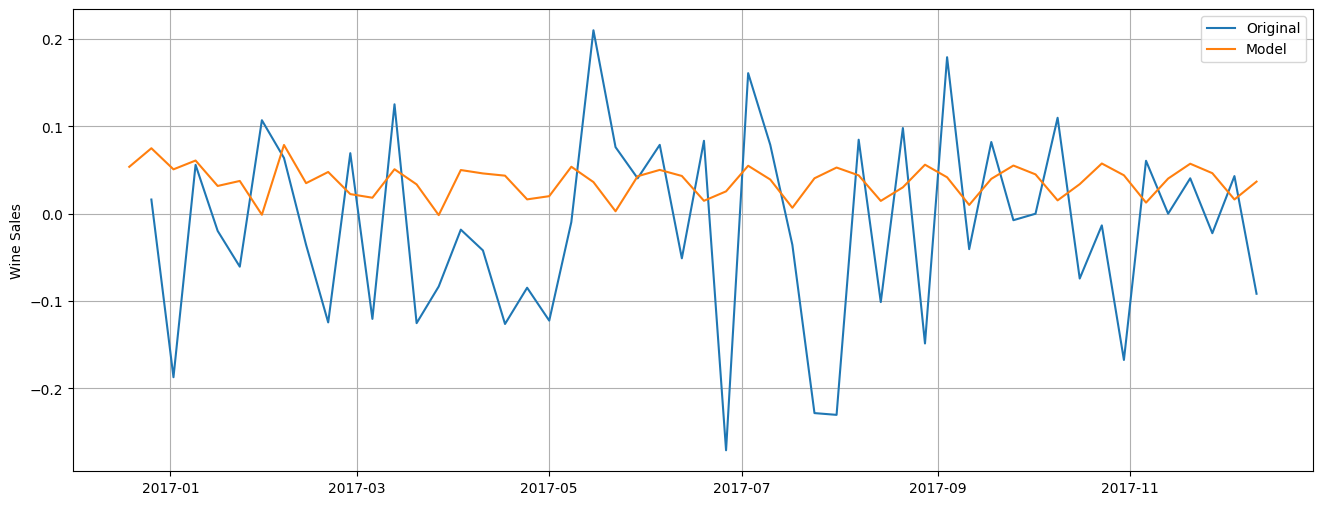

In [ ]:
forecast = best_model.predict(start=train_data.index[-1], end=test_data.index[-1])

plt.figure(figsize=(16, 6))
plt.plot(test_data, label='Original')
plt.plot(forecast, label='Model')
plt.ylabel('Wine Sales')
plt.grid(True)
plt.legend();

In [ ]:
# оцениваем качество
print('SMAPE (Test Data): ', symmetric_mean_absolute_percentage_error(test_data, forecast[1:]))
print('RMSE (Test Data): ', root_mean_squared_error(test_data, forecast[1:]))
print('WAPE (Test Data)', weighted_absolute_percentage_error(test_data, forecast[1:]))

SMAPE (Test Data):  156.62819868284544
RMSE (Test Data):  0.12092205845744279
WAPE (Test Data) 1.1114035911038855
